# Create the k-fold directories

In [1]:
import json
from pathlib import Path
import os
import shutil
import cv2
import itertools
import numpy as np
import pandas as pd
from typing import List, Dict
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold
import os
from pathlib import Path

In [2]:
import staintools

In [3]:
DATA_DIR = Path('../data/')

In [4]:
# Read .jsonl file and convert it to a list of dicts
# The dicts contain IDs, class names and segmentation masks
# from https://www.kaggle.com/code/leonidkulyk/eda-hubmap-hhv-interactive-annotations
with open(DATA_DIR / 'cleaned_polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

id_to_annotation = {j['id']: j['annotations'] for j in json_labels}

In [5]:
# Define a conversion between class name and number
id_dict = {'blood_vessel': 0, 'glomerulus': 1, 'unsure': 2}

In [6]:
# Function to copy images and transform labels to 
# coco formatted .txt files
def tile_to_coco(tile_id, annotations, output_folder: Path):
    # Copy image
    shutil.copyfile(DATA_DIR / f'train/{tile_id}.tif', output_folder / f'{tile_id}.tif')
    
    # Create text file and write formatted labels to it
    with open(output_folder / f'{tile_id}.txt', 'w') as text_file:
        for annotation in annotations:
            
            class_id = id_dict[annotation['type']]
            if class_id == 2:
                continue
            flat_mask_polygon = list(itertools.chain(*annotation['coordinates'][0]))
            # Divide by 512 because coco labels expect positions between 0 and 1
            # not pixel indices
            array = np.array(flat_mask_polygon)/512.
            text_file.write(f'{class_id} {" ".join(map(str, array))}\n')
            
        

In [115]:
# Function to copy images and transform labels to 
# coco formatted .txt files
def tile_to_coco_stain(tile_id, annotations, output_folder: Path, stain_num=0):
    
    # Read data
    image = staintools.read_image(str(DATA_DIR / f'train/{tile_id}.tif'))
    image = staintools.LuminosityStandardizer.standardize(image)
    
    if stain_num == 0:
        cv2.imwrite(str(output_folder / f'{tile_id}.tif'), image[...,::-1])
        # Create text file and write formatted labels to it
        with open(output_folder / f'{tile_id}.txt', 'w') as text_file:
            for annotation in annotations:

                class_id = id_dict[annotation['type']]
                if class_id == 2:
                    continue
                flat_mask_polygon = list(itertools.chain(*annotation['coordinates'][0]))
                # Divide by 512 because coco labels expect positions between 0 and 1
                # not pixel indices
                array = np.array(flat_mask_polygon)/512.
                text_file.write(f'{class_id} {" ".join(map(str, array))}\n')

    else:
        augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.3, sigma2=0.3)
        augmentor.fit(image)
        for i in range(stain_num+1):
            if i != 0:
                image = augmentor.pop().astype(np.uint8)
                
            cv2.imwrite(str(output_folder / f'{tile_id}_{i}.tif'), image[...,::-1])
            # Create text file and write formatted labels to it
            with open(output_folder / f'{tile_id}_{i}.txt', 'w') as text_file:
                for annotation in annotations:

                    class_id = id_dict[annotation['type']]
                    if class_id == 2:
                        continue
                    flat_mask_polygon = list(itertools.chain(*annotation['coordinates'][0]))
                    # Divide by 512 because coco labels expect positions between 0 and 1
                    # not pixel indices
                    array = np.array(flat_mask_polygon)/512.
                    text_file.write(f'{class_id} {" ".join(map(str, array))}\n')

In [8]:
meta = pd.read_csv(DATA_DIR / 'tile_meta.csv')

In [9]:
meta.dataset.value_counts()

3    5400
2    1211
1     422
Name: dataset, dtype: int64

In [10]:
rows = []
with open(f'{DATA_DIR}/cleaned_polygons.jsonl', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        row = dict({'id': data['id']})
        coords = []
        for ann in data['annotations']:
            if ann['type'] == 'blood_vessel':
                coords.append(ann['coordinates'])
        row['annotation'] = coords
        
        rows.append(row)
df = pd.DataFrame(rows)

In [11]:
df = df.merge(meta, on='id')

In [12]:
# df = df[df.dataset == 1]

In [13]:
df['num_cells'] = df['annotation'].apply(lambda x: len(x))

In [14]:
df["area"] = df["annotation"].apply(lambda xs: sum([cv2.contourArea(np.array(x)) for x in xs])/512**2) # You might need a different function to calculate the area depending on the structure of annotation

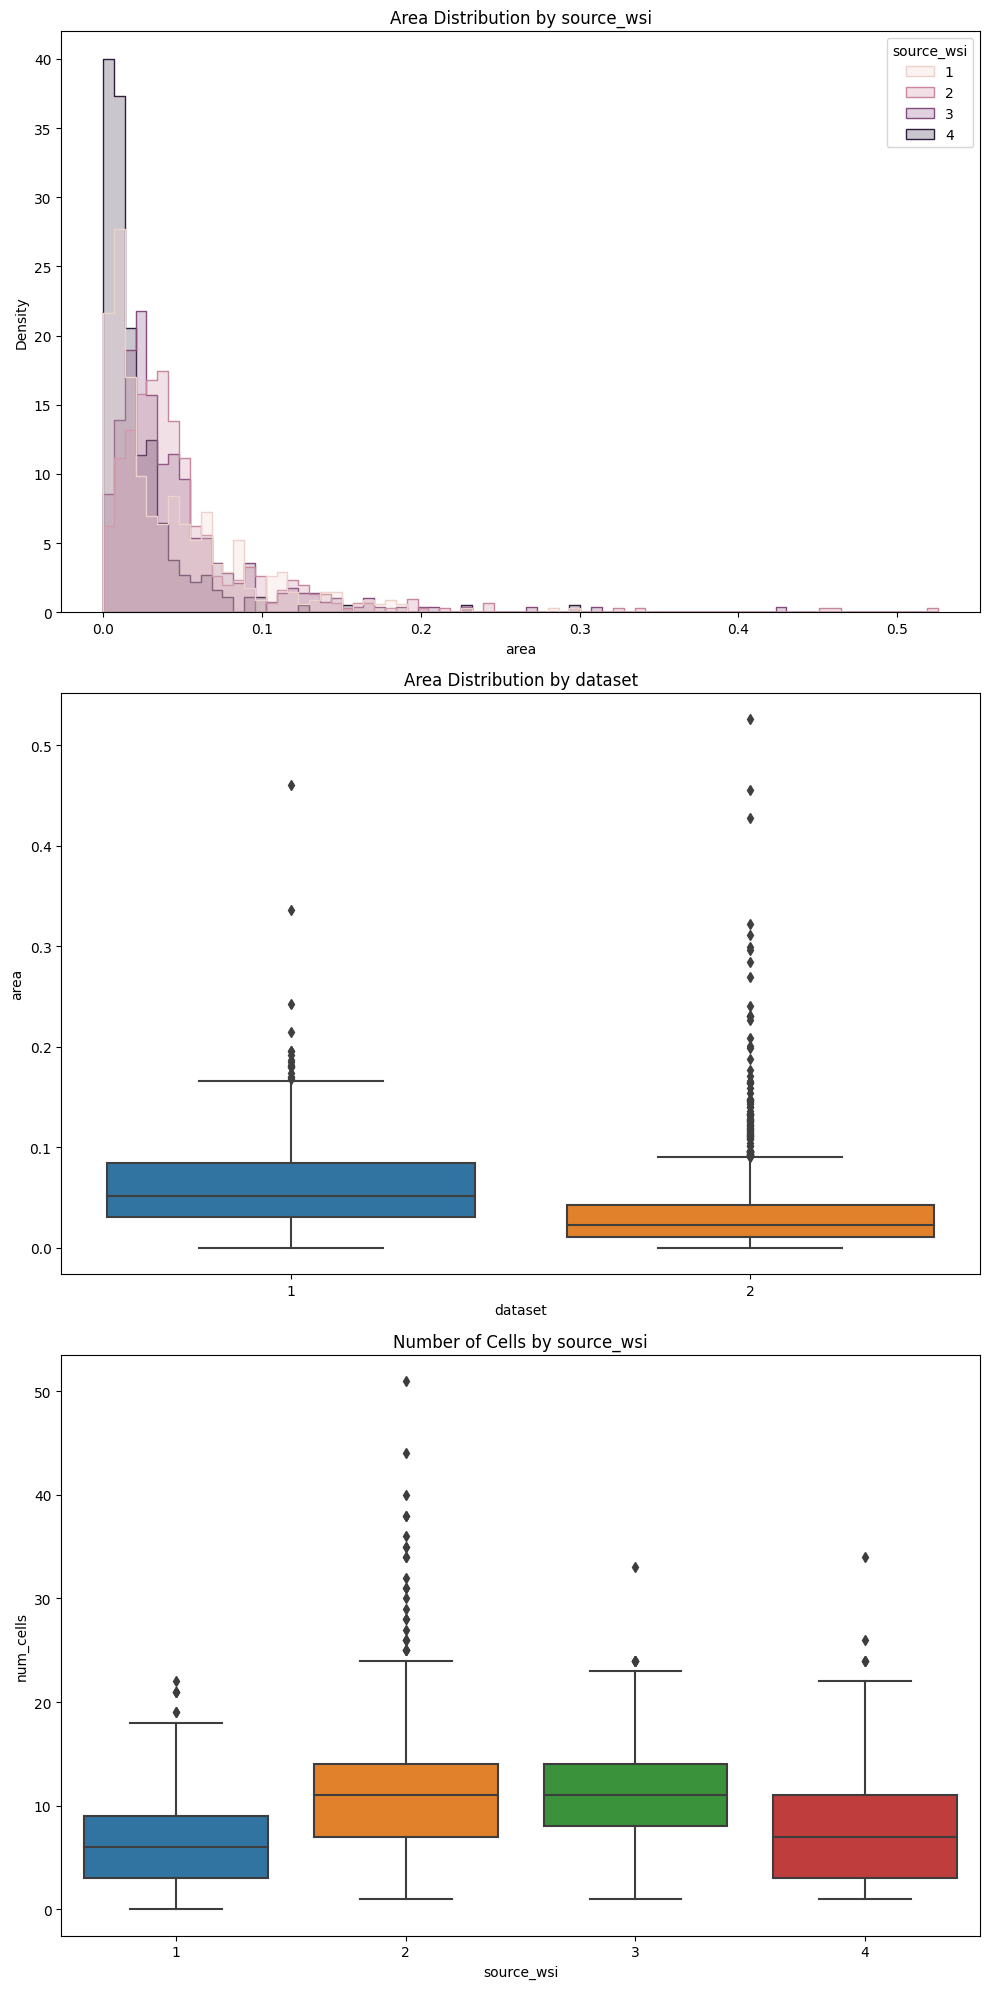

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(3, figsize=(10, 20))

# Plot histograms of areas
sns.histplot(df, x="area", hue="source_wsi", element="step", stat="density", common_norm=False, ax=axes[0])
axes[0].set_title('Area Distribution by source_wsi')

sns.boxplot(df, x="dataset", y="area", ax=axes[1])
axes[1].set_title('Area Distribution by dataset')

# Plot boxplots of num_cells
sns.boxplot(x="source_wsi", y="num_cells", data=df, ax=axes[2])
axes[2].set_title('Number of Cells by source_wsi')

plt.tight_layout()
plt.show()

In [16]:
df["num_cells_binned"] = pd.qcut(df["num_cells"], q=4, labels=False, duplicates='drop')
df["area_binned"] = pd.qcut(df["area"], q=4, labels=False, duplicates='drop')

In [17]:
df_encoded = pd.get_dummies(df, columns=["num_cells_binned", "area_binned", "source_wsi"])

In [18]:
stratify_cols = [col for col in df_encoded.columns if "num_cells_binned" in col or "area_binned" in col or "source_wsi" in col]
df_stratify = df_encoded[stratify_cols]

In [19]:
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# # Извлечь данные из dataset 1 и dataset 2
# df1 = df[df.dataset==1]
# df2 = df[df.dataset==2]

# # Выделить признаки для сравнения
# features = ['area', 'num_cells']
# df1_features = df1[features]
# df2_features = df2[features]

# # Масштабировать признаки
# scaler = StandardScaler()
# df1_features_scaled = scaler.fit_transform(df1_features)
# df2_features_scaled = scaler.transform(df2_features)

# # Обучить модель NearestNeighbors на dataset 1
# nbrs = NearestNeighbors(n_neighbors=1).fit(df1_features_scaled)

# # Найти ближайшие соседи в dataset 1 для каждого элемента в dataset 2
# distances, indices = nbrs.kneighbors(df2_features_scaled)

# # Отбор индексов dataset 2, которые ближе всего к dataset 1
# df2_closest = df2.iloc[indices.flatten()]

In [20]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=5)

## Folds directories

In [21]:
FOLD_DIR = 'loo_stained_wsi'

In [22]:
# Assuming k=5 for 5-fold cross-validation
# k = 5
k = 4

# Create the k-fold directories
for i in range(k):
    fold_dir = f'{FOLD_DIR}/fold{i}/'
    os.makedirs(fold_dir)
    os.makedirs(fold_dir + 'train/')
    os.makedirs(fold_dir + 'valid/')

## Split Data

In [23]:
num_dict = {1: 2, 2: 2, 3: 2, 3: 2}

In [28]:
from tqdm.notebook import tqdm_notebook as tqdm

In [116]:
for fold_index, source_wsi in enumerate(sorted(df.source_wsi.unique())):
    valid_idx = df[df.source_wsi == source_wsi]['id'].values
    train_idx = df[df.source_wsi != source_wsi]['id'].values
    
    fold_dir = f'{FOLD_DIR}/fold{fold_index}/'
    
    # Copy the train and valid data to the corresponding fold directory
    for i in tqdm(train_idx):
        tile_to_coco_stain(i, id_to_annotation[i] , Path(fold_dir + 'train/'), stain_num=5)
    for j in valid_idx:
        tile_to_coco_stain(j, id_to_annotation[j] , Path(fold_dir + 'valid/'), stain_num=0)

    # Create the hubmap-coco.yaml file for each fold
    yaml_text = f"""
    # HuBMAP - Hacking the Human Vasculature dataset 
    # https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature

    # train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
    train: {str(Path(fold_dir + 'train/').absolute())}
    val: {str(Path(fold_dir + 'valid/').absolute())}

    # class names
    names: 
      0: blood_vessel
      1: glomerulus
      
    """

    with open(fold_dir + 'hubmap-coco.yaml', 'w') as text_file:
        text_file.write(yaml_text)

  0%|          | 0/1126 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# # Perform the split
# for fold_index, (train_idx, valid_idx) in enumerate(mskf.split(df_encoded, df_stratify)):
#     train_idx = df_encoded.iloc[train_idx]['id'].values
#     valid_idx = df_encoded.iloc[valid_idx]['id'].values

#     fold_dir = f'{FOLD_DIR}/fold{fold_index}/'

#     # Copy the train and valid data to the corresponding fold directory
#     for i in train_idx:
#         tile_to_coco(i, id_to_annotation[i] , Path(fold_dir + 'train/'))
#     for j in valid_idx:
#         tile_to_coco(j, id_to_annotation[j] , Path(fold_dir + 'valid/'))

#     # Create the hubmap-coco.yaml file for each fold
#     yaml_text = f"""
#     # HuBMAP - Hacking the Human Vasculature dataset 
#     # https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature

#     # train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
#     train: {str(Path(fold_dir + 'train/').absolute())}
#     val: {str(Path(fold_dir + 'valid/').absolute())}

#     # class names
#     names: 
#       0: blood_vessel
#     """

#     with open(fold_dir + 'hubmap-coco.yaml', 'w') as text_file:
#         text_file.write(yaml_text)